In [23]:
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [ ]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

train_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(128, scale=(0.7, 1.0)),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

val_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=(128, 128)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_dataset = torchvision.datasets.Imagenette(
    ".", split="train", download=True, transform=train_transforms
)
val_dataset = torchvision.datasets.Imagenette(
    ".", split="val", download=True, transform=val_transforms
)
val_dataset, test_dataset = random_split(
    val_dataset,
    lengths=[
        int(len(val_dataset) / 3 * 2),
        len(val_dataset) - int(len(val_dataset) / 3 * 2),
    ],
)

device

'cuda'

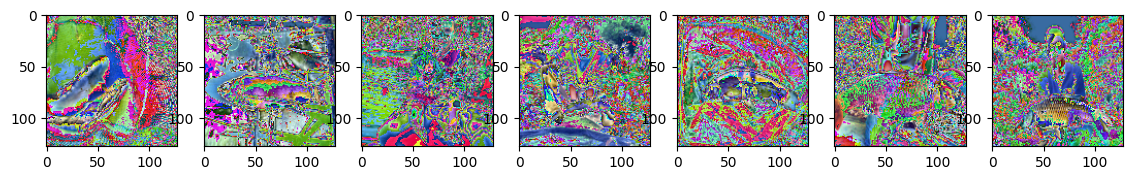

In [25]:
def show_in_row(dataset):
    plt.figure(figsize=(20, 8))
    for i in range(7):
        plt.subplot(1, 10, i + 1)
        plt.imshow(v2.ToPILImage()(dataset[i][0]))
    plt.show()


show_in_row(train_dataset)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes, fe_dropout=0.1, cl_dropout=0.5):
        super(CNN, self).__init__()

        # Feature Extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1),  # 62x62x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 30x30x64
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 30x30x192
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 14x14x192
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 14x14x384
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 14x14x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 14x14x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 6x6x256
            nn.Dropout(p=fe_dropout),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=cl_dropout),
            nn.Linear(256 * 6 * 6, 4096),  # FC1
            nn.ReLU(inplace=True),
            nn.Dropout(p=cl_dropout),
            nn.Linear(4096, 4096),  # FC2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # FC3
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [29]:
num_epochs = 80
batch_size = 64
learning_rate = 0.001
out_classes = 10
checkpoint_step = 5

model = CNN(out_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=6,
    persistent_workers=True,
)
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=6,
    persistent_workers=True,
)

In [30]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}"
    )

    model.eval()
    total, correct = 0, 0
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_val_loss += val_loss.item()

    accuracy = 100 * correct / total
    print(
        f"Accuracy: {accuracy:.2f}% Validation Loss: {running_val_loss / len(valloader):.4f}"
    )

    if (epoch + 1) % checkpoint_step == 0:
        torch.save(
            {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": loss,
                "val_loss": val_loss,
                "accuracy": accuracy,
            },
            f"epoch_{epoch + 1}.pth",
        )

        print(f"Epoch #{epoch + 1} saved")

100%|██████████| 148/148 [00:18<00:00,  7.81it/s]


Epoch [1/80], Loss: 2.7796


100%|██████████| 62/62 [00:15<00:00,  3.95it/s]


Accuracy: 20.87% Validation Loss: 2.1279


100%|██████████| 148/148 [00:06<00:00, 21.93it/s]


Epoch [2/80], Loss: 2.0822


100%|██████████| 62/62 [00:02<00:00, 24.67it/s]


Accuracy: 24.76% Validation Loss: 2.0397


100%|██████████| 148/148 [00:06<00:00, 21.66it/s]


Epoch [3/80], Loss: 1.9968


100%|██████████| 62/62 [00:02<00:00, 25.06it/s]


Accuracy: 31.31% Validation Loss: 1.8985


100%|██████████| 148/148 [00:06<00:00, 21.73it/s]


Epoch [4/80], Loss: 1.9229


100%|██████████| 62/62 [00:02<00:00, 24.88it/s]


Accuracy: 30.88% Validation Loss: 1.9185


100%|██████████| 148/148 [00:06<00:00, 21.91it/s]


Epoch [5/80], Loss: 1.8571


100%|██████████| 62/62 [00:02<00:00, 24.81it/s]


Accuracy: 37.71% Validation Loss: 1.8262
Epoch #4 saved


100%|██████████| 148/148 [00:06<00:00, 21.76it/s]


Epoch [6/80], Loss: 1.7376


100%|██████████| 62/62 [00:02<00:00, 24.70it/s]


Accuracy: 39.34% Validation Loss: 1.7669


100%|██████████| 148/148 [00:06<00:00, 21.59it/s]


Epoch [7/80], Loss: 1.6421


100%|██████████| 62/62 [00:02<00:00, 24.72it/s]


Accuracy: 40.79% Validation Loss: 1.6675


100%|██████████| 148/148 [00:07<00:00, 20.78it/s]


Epoch [8/80], Loss: 1.5827


100%|██████████| 62/62 [00:02<00:00, 24.12it/s]


Accuracy: 44.87% Validation Loss: 1.6287


100%|██████████| 148/148 [00:06<00:00, 21.38it/s]


Epoch [9/80], Loss: 1.5264


100%|██████████| 62/62 [00:02<00:00, 22.29it/s]


Accuracy: 50.45% Validation Loss: 1.4739


100%|██████████| 148/148 [00:07<00:00, 20.39it/s]


Epoch [10/80], Loss: 1.4502


100%|██████████| 62/62 [00:02<00:00, 27.73it/s]


Accuracy: 53.27% Validation Loss: 1.4327
Epoch #9 saved


100%|██████████| 148/148 [00:06<00:00, 22.19it/s]


Epoch [11/80], Loss: 1.3984


100%|██████████| 62/62 [00:02<00:00, 26.36it/s]


Accuracy: 57.02% Validation Loss: 1.3579


100%|██████████| 148/148 [00:07<00:00, 21.11it/s]


Epoch [12/80], Loss: 1.3248


100%|██████████| 62/62 [00:02<00:00, 28.09it/s]


Accuracy: 55.85% Validation Loss: 1.4144


100%|██████████| 148/148 [00:06<00:00, 22.22it/s]


Epoch [13/80], Loss: 1.2675


100%|██████████| 62/62 [00:02<00:00, 26.69it/s]


Accuracy: 60.13% Validation Loss: 1.3553


100%|██████████| 148/148 [00:06<00:00, 21.87it/s]


Epoch [14/80], Loss: 1.2344


100%|██████████| 62/62 [00:02<00:00, 27.73it/s]


Accuracy: 60.71% Validation Loss: 1.2298


100%|██████████| 148/148 [00:06<00:00, 22.02it/s]


Epoch [15/80], Loss: 1.1653


100%|██████████| 62/62 [00:02<00:00, 27.25it/s]


Accuracy: 59.77% Validation Loss: 1.2848
Epoch #14 saved


100%|██████████| 148/148 [00:06<00:00, 21.96it/s]


Epoch [16/80], Loss: 1.1210


100%|██████████| 62/62 [00:02<00:00, 26.93it/s]


Accuracy: 63.77% Validation Loss: 1.1954


100%|██████████| 148/148 [00:06<00:00, 22.11it/s]


Epoch [17/80], Loss: 1.0946


100%|██████████| 62/62 [00:02<00:00, 27.02it/s]


Accuracy: 66.06% Validation Loss: 1.1811


100%|██████████| 148/148 [00:07<00:00, 19.74it/s]


Epoch [18/80], Loss: 1.0602


100%|██████████| 62/62 [00:02<00:00, 23.81it/s]


Accuracy: 64.43% Validation Loss: 1.1568


100%|██████████| 148/148 [00:07<00:00, 19.69it/s]


Epoch [19/80], Loss: 0.9998


100%|██████████| 62/62 [00:02<00:00, 26.41it/s]


Accuracy: 58.68% Validation Loss: 1.2887


100%|██████████| 148/148 [00:07<00:00, 20.53it/s]


Epoch [20/80], Loss: 0.9811


100%|██████████| 62/62 [00:02<00:00, 26.56it/s]


Accuracy: 67.29% Validation Loss: 1.1064
Epoch #19 saved


100%|██████████| 148/148 [00:06<00:00, 22.17it/s]


Epoch [21/80], Loss: 0.9416


100%|██████████| 62/62 [00:02<00:00, 26.73it/s]


Accuracy: 66.45% Validation Loss: 1.1083


100%|██████████| 148/148 [00:06<00:00, 21.99it/s]


Epoch [22/80], Loss: 0.9298


100%|██████████| 62/62 [00:02<00:00, 27.13it/s]


Accuracy: 67.72% Validation Loss: 1.0760


100%|██████████| 148/148 [00:06<00:00, 22.23it/s]


Epoch [23/80], Loss: 0.9017


100%|██████████| 62/62 [00:02<00:00, 27.39it/s]


Accuracy: 69.07% Validation Loss: 1.0601


100%|██████████| 148/148 [00:06<00:00, 22.14it/s]


Epoch [24/80], Loss: 0.8492


100%|██████████| 62/62 [00:02<00:00, 27.51it/s]


Accuracy: 70.57% Validation Loss: 1.0164


100%|██████████| 148/148 [00:06<00:00, 21.85it/s]


Epoch [25/80], Loss: 0.8462


100%|██████████| 62/62 [00:02<00:00, 27.09it/s]


Accuracy: 72.33% Validation Loss: 0.9881
Epoch #24 saved


100%|██████████| 148/148 [00:06<00:00, 21.97it/s]


Epoch [26/80], Loss: 0.8093


100%|██████████| 62/62 [00:02<00:00, 27.25it/s]


Accuracy: 73.27% Validation Loss: 0.9074


100%|██████████| 148/148 [00:06<00:00, 22.17it/s]


Epoch [27/80], Loss: 0.7770


100%|██████████| 62/62 [00:02<00:00, 27.45it/s]


Accuracy: 73.71% Validation Loss: 0.9611


100%|██████████| 148/148 [00:06<00:00, 22.16it/s]


Epoch [28/80], Loss: 0.7726


100%|██████████| 62/62 [00:02<00:00, 27.00it/s]


Accuracy: 68.46% Validation Loss: 1.0945


100%|██████████| 148/148 [00:06<00:00, 21.90it/s]


Epoch [29/80], Loss: 0.7523


100%|██████████| 62/62 [00:02<00:00, 27.00it/s]


Accuracy: 68.87% Validation Loss: 1.0434


100%|██████████| 148/148 [00:07<00:00, 20.17it/s]


Epoch [30/80], Loss: 0.7254


100%|██████████| 62/62 [00:02<00:00, 24.35it/s]


Accuracy: 75.21% Validation Loss: 0.8439
Epoch #29 saved


100%|██████████| 148/148 [00:07<00:00, 20.37it/s]


Epoch [31/80], Loss: 0.7003


100%|██████████| 62/62 [00:02<00:00, 23.43it/s]


Accuracy: 74.34% Validation Loss: 0.8761


100%|██████████| 148/148 [00:07<00:00, 20.30it/s]


Epoch [32/80], Loss: 0.6714


100%|██████████| 62/62 [00:02<00:00, 23.68it/s]


Accuracy: 71.52% Validation Loss: 0.9479


100%|██████████| 148/148 [00:07<00:00, 20.28it/s]


Epoch [33/80], Loss: 0.6596


100%|██████████| 62/62 [00:02<00:00, 23.36it/s]


Accuracy: 74.60% Validation Loss: 0.8199


100%|██████████| 148/148 [00:07<00:00, 20.38it/s]


Epoch [34/80], Loss: 0.6258


100%|██████████| 62/62 [00:02<00:00, 24.15it/s]


Accuracy: 76.79% Validation Loss: 0.7742


100%|██████████| 148/148 [00:07<00:00, 20.39it/s]


Epoch [35/80], Loss: 0.6100


100%|██████████| 62/62 [00:02<00:00, 24.73it/s]


Accuracy: 77.30% Validation Loss: 0.7561
Epoch #34 saved


100%|██████████| 148/148 [00:07<00:00, 20.20it/s]


Epoch [36/80], Loss: 0.5898


100%|██████████| 62/62 [00:02<00:00, 24.48it/s]


Accuracy: 76.59% Validation Loss: 0.7445


100%|██████████| 148/148 [00:07<00:00, 20.54it/s]


Epoch [37/80], Loss: 0.5607


100%|██████████| 62/62 [00:02<00:00, 24.19it/s]


Accuracy: 74.39% Validation Loss: 0.8193


100%|██████████| 148/148 [00:07<00:00, 20.56it/s]


Epoch [38/80], Loss: 0.5535


100%|██████████| 62/62 [00:02<00:00, 23.65it/s]


Accuracy: 76.46% Validation Loss: 0.7512


100%|██████████| 148/148 [00:07<00:00, 20.19it/s]


Epoch [39/80], Loss: 0.5326


100%|██████████| 62/62 [00:02<00:00, 23.98it/s]


Accuracy: 79.49% Validation Loss: 0.6861


100%|██████████| 148/148 [00:07<00:00, 20.44it/s]


Epoch [40/80], Loss: 0.5075


100%|██████████| 62/62 [00:02<00:00, 27.03it/s]


Accuracy: 77.63% Validation Loss: 0.7148
Epoch #39 saved


100%|██████████| 148/148 [00:06<00:00, 22.07it/s]


Epoch [41/80], Loss: 0.4998


100%|██████████| 62/62 [00:02<00:00, 27.23it/s]


Accuracy: 77.40% Validation Loss: 0.7585


100%|██████████| 148/148 [00:06<00:00, 22.03it/s]


Epoch [42/80], Loss: 0.4825


100%|██████████| 62/62 [00:02<00:00, 27.07it/s]


Accuracy: 74.39% Validation Loss: 0.8357


100%|██████████| 148/148 [00:06<00:00, 22.06it/s]


Epoch [43/80], Loss: 0.4696


100%|██████████| 62/62 [00:02<00:00, 27.37it/s]


Accuracy: 78.78% Validation Loss: 0.6807


100%|██████████| 148/148 [00:06<00:00, 21.99it/s]


Epoch [44/80], Loss: 0.4482


100%|██████████| 62/62 [00:02<00:00, 26.79it/s]


Accuracy: 80.87% Validation Loss: 0.6403


100%|██████████| 148/148 [00:06<00:00, 22.02it/s]


Epoch [45/80], Loss: 0.4332


100%|██████████| 62/62 [00:02<00:00, 27.25it/s]


Accuracy: 78.42% Validation Loss: 0.7420
Epoch #44 saved


100%|██████████| 148/148 [00:06<00:00, 22.02it/s]


Epoch [46/80], Loss: 0.4147


100%|██████████| 62/62 [00:02<00:00, 27.01it/s]


Accuracy: 77.81% Validation Loss: 0.7827


100%|██████████| 148/148 [00:06<00:00, 22.10it/s]


Epoch [47/80], Loss: 0.4130


100%|██████████| 62/62 [00:02<00:00, 27.14it/s]


Accuracy: 77.40% Validation Loss: 0.7314


100%|██████████| 148/148 [00:06<00:00, 21.84it/s]


Epoch [48/80], Loss: 0.3973


100%|██████████| 62/62 [00:02<00:00, 27.05it/s]


Accuracy: 78.22% Validation Loss: 0.6904


100%|██████████| 148/148 [00:06<00:00, 22.35it/s]


Epoch [49/80], Loss: 0.3917


100%|██████████| 62/62 [00:02<00:00, 27.56it/s]


Accuracy: 76.97% Validation Loss: 0.7140


100%|██████████| 148/148 [00:06<00:00, 22.58it/s]


Epoch [50/80], Loss: 0.3670


100%|██████████| 62/62 [00:02<00:00, 27.69it/s]


Accuracy: 80.25% Validation Loss: 0.7032
Epoch #49 saved


100%|██████████| 148/148 [00:06<00:00, 22.31it/s]


Epoch [51/80], Loss: 0.3636


100%|██████████| 62/62 [00:02<00:00, 28.11it/s]


Accuracy: 79.31% Validation Loss: 0.6587


100%|██████████| 148/148 [00:06<00:00, 22.45it/s]


Epoch [52/80], Loss: 0.3368


100%|██████████| 62/62 [00:02<00:00, 27.79it/s]


Accuracy: 77.86% Validation Loss: 0.8517


100%|██████████| 148/148 [00:06<00:00, 22.14it/s]


Epoch [53/80], Loss: 0.3257


100%|██████████| 62/62 [00:02<00:00, 27.18it/s]


Accuracy: 79.97% Validation Loss: 0.7031


100%|██████████| 148/148 [00:06<00:00, 22.47it/s]


Epoch [54/80], Loss: 0.3243


100%|██████████| 62/62 [00:02<00:00, 27.61it/s]


Accuracy: 80.36% Validation Loss: 0.7172


100%|██████████| 148/148 [00:06<00:00, 22.11it/s]


Epoch [55/80], Loss: 0.3096


100%|██████████| 62/62 [00:02<00:00, 27.08it/s]


Accuracy: 78.42% Validation Loss: 0.7096
Epoch #54 saved


100%|██████████| 148/148 [00:06<00:00, 22.08it/s]


Epoch [56/80], Loss: 0.3045


100%|██████████| 62/62 [00:02<00:00, 27.26it/s]


Accuracy: 79.11% Validation Loss: 0.7272


100%|██████████| 148/148 [00:06<00:00, 21.99it/s]


Epoch [57/80], Loss: 0.2896


100%|██████████| 62/62 [00:02<00:00, 24.97it/s]


Accuracy: 81.63% Validation Loss: 0.6306


100%|██████████| 148/148 [00:07<00:00, 20.59it/s]


Epoch [58/80], Loss: 0.2903


100%|██████████| 62/62 [00:02<00:00, 23.71it/s]


Accuracy: 81.53% Validation Loss: 0.6816


100%|██████████| 148/148 [00:06<00:00, 21.56it/s]


Epoch [59/80], Loss: 0.2747


100%|██████████| 62/62 [00:02<00:00, 26.06it/s]


Accuracy: 81.12% Validation Loss: 0.6590


100%|██████████| 148/148 [00:07<00:00, 20.54it/s]


Epoch [60/80], Loss: 0.2752


100%|██████████| 62/62 [00:02<00:00, 22.28it/s]


Accuracy: 80.92% Validation Loss: 0.6740
Epoch #59 saved


100%|██████████| 148/148 [00:06<00:00, 21.17it/s]


Epoch [61/80], Loss: 0.2664


100%|██████████| 62/62 [00:02<00:00, 26.81it/s]


Accuracy: 80.46% Validation Loss: 0.6919


100%|██████████| 148/148 [00:06<00:00, 22.12it/s]


Epoch [62/80], Loss: 0.2579


100%|██████████| 62/62 [00:02<00:00, 26.98it/s]


Accuracy: 78.83% Validation Loss: 0.7050


100%|██████████| 148/148 [00:06<00:00, 22.25it/s]


Epoch [63/80], Loss: 0.2482


100%|██████████| 62/62 [00:02<00:00, 27.48it/s]


Accuracy: 81.45% Validation Loss: 0.7465


100%|██████████| 148/148 [00:06<00:00, 22.54it/s]


Epoch [64/80], Loss: 0.2397


100%|██████████| 62/62 [00:02<00:00, 27.43it/s]


Accuracy: 81.94% Validation Loss: 0.6376


100%|██████████| 148/148 [00:06<00:00, 22.15it/s]


Epoch [65/80], Loss: 0.2275


100%|██████████| 62/62 [00:02<00:00, 27.54it/s]


Accuracy: 80.51% Validation Loss: 0.7373
Epoch #64 saved


100%|██████████| 148/148 [00:06<00:00, 21.97it/s]


Epoch [66/80], Loss: 0.2148


100%|██████████| 62/62 [00:02<00:00, 27.05it/s]


Accuracy: 81.15% Validation Loss: 0.7475


100%|██████████| 148/148 [00:06<00:00, 21.82it/s]


Epoch [67/80], Loss: 0.2287


100%|██████████| 62/62 [00:02<00:00, 25.79it/s]


Accuracy: 81.71% Validation Loss: 0.6774


100%|██████████| 148/148 [00:06<00:00, 21.77it/s]


Epoch [68/80], Loss: 0.2183


100%|██████████| 62/62 [00:02<00:00, 27.70it/s]


Accuracy: 79.59% Validation Loss: 0.7547


100%|██████████| 148/148 [00:06<00:00, 22.03it/s]


Epoch [69/80], Loss: 0.2388


100%|██████████| 62/62 [00:02<00:00, 27.87it/s]


Accuracy: 81.89% Validation Loss: 0.6389


100%|██████████| 148/148 [00:06<00:00, 22.34it/s]


Epoch [70/80], Loss: 0.1887


100%|██████████| 62/62 [00:02<00:00, 28.04it/s]


Accuracy: 81.45% Validation Loss: 0.7146
Epoch #69 saved


100%|██████████| 148/148 [00:06<00:00, 22.13it/s]


Epoch [71/80], Loss: 0.2126


100%|██████████| 62/62 [00:02<00:00, 27.11it/s]


Accuracy: 82.24% Validation Loss: 0.6203


100%|██████████| 148/148 [00:06<00:00, 22.27it/s]


Epoch [72/80], Loss: 0.1885


100%|██████████| 62/62 [00:02<00:00, 27.44it/s]


Accuracy: 82.09% Validation Loss: 0.7067


100%|██████████| 148/148 [00:06<00:00, 22.27it/s]


Epoch [73/80], Loss: 0.1832


100%|██████████| 62/62 [00:02<00:00, 27.04it/s]


Accuracy: 81.22% Validation Loss: 0.7180


100%|██████████| 148/148 [00:06<00:00, 22.46it/s]


Epoch [74/80], Loss: 0.1785


100%|██████████| 62/62 [00:02<00:00, 28.07it/s]


Accuracy: 79.75% Validation Loss: 0.7784


100%|██████████| 148/148 [00:06<00:00, 22.44it/s]


Epoch [75/80], Loss: 0.1647


100%|██████████| 62/62 [00:02<00:00, 27.49it/s]


Accuracy: 83.13% Validation Loss: 0.7148
Epoch #74 saved


100%|██████████| 148/148 [00:06<00:00, 22.00it/s]


Epoch [76/80], Loss: 0.1700


100%|██████████| 62/62 [00:02<00:00, 27.60it/s]


Accuracy: 82.65% Validation Loss: 0.6650


100%|██████████| 148/148 [00:06<00:00, 22.09it/s]


Epoch [77/80], Loss: 0.1641


100%|██████████| 62/62 [00:02<00:00, 27.33it/s]


Accuracy: 79.77% Validation Loss: 0.8051


100%|██████████| 148/148 [00:06<00:00, 22.17it/s]


Epoch [78/80], Loss: 0.1727


100%|██████████| 62/62 [00:02<00:00, 27.32it/s]


Accuracy: 81.30% Validation Loss: 0.7182


100%|██████████| 148/148 [00:06<00:00, 22.25it/s]


Epoch [79/80], Loss: 0.1695


100%|██████████| 62/62 [00:02<00:00, 27.71it/s]


Accuracy: 79.16% Validation Loss: 0.8402


100%|██████████| 148/148 [00:06<00:00, 22.43it/s]


Epoch [80/80], Loss: 0.1552


100%|██████████| 62/62 [00:02<00:00, 28.10it/s]


Accuracy: 82.78% Validation Loss: 0.6971
Epoch #79 saved
